In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import json
from tqdm import tqdm
import pickle

from custom_dataset import METEORDataLayer, METEOR_3D
import transformer_models
from custom_utils import evaluate_experiment
from torch.utils.data import DataLoader

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# set constants
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

os.getcwd()

'/workspace/persistent/thesis/OadTR'

/opt/conda/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/thesis/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


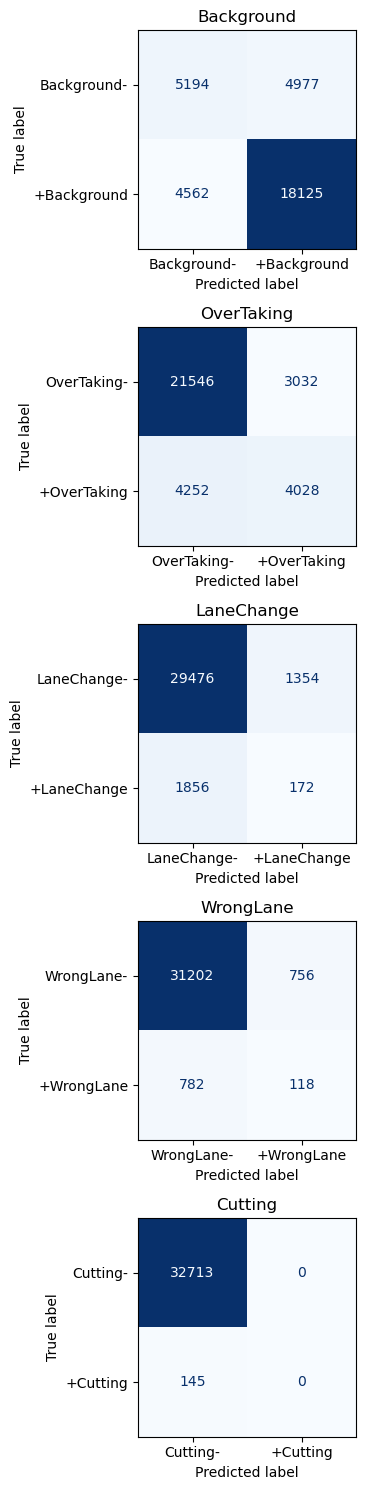

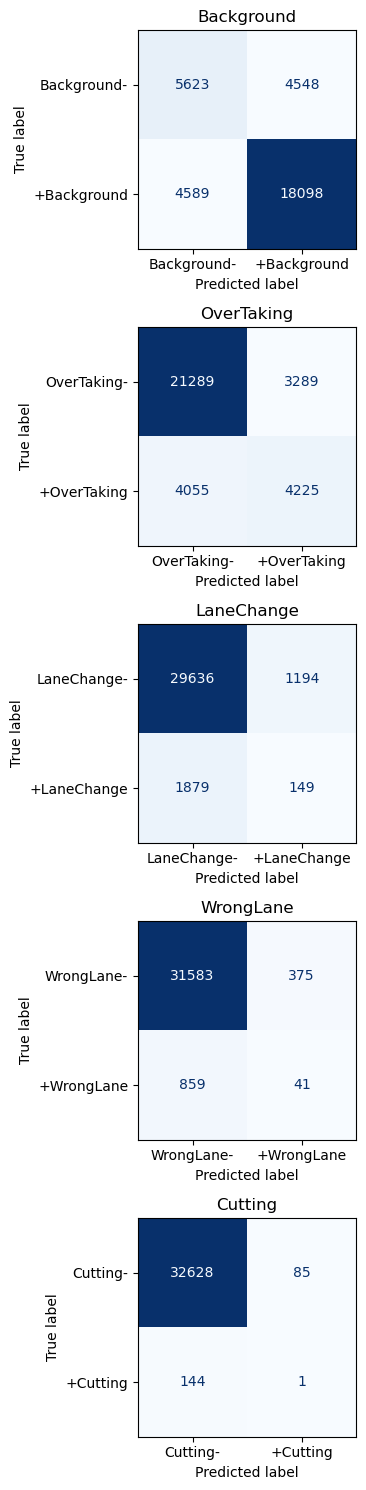

In [2]:
directories = ['experiments/v4_model/new_model_long_train', 'experiments/v4_model/std_model_long_train']
for dir in directories:
    evaluate_experiment(dir)

In [8]:
old_df = pd.DataFrame([returned_metrics.values()], columns = returned_metrics.keys(), index = [directory])
new_df = pd.DataFrame([returned_metrics.values()], columns = returned_metrics.keys(), index = [1])

pd.concat([old_df, new_df], axis=0)

,weighted_roc_auc,weighted_f1,weighted_precision,weighted_recall,Background_f1,Background_precision,Background_recall,OverTaking_f1,OverTaking_precision,OverTaking_recall,LaneChange_f1,LaneChange_precision,LaneChange_recall,WrongLane_f1,WrongLane_precision,WrongLane_recall,Cutting_f1,Cutting_precision,Cutting_recall
experiments/v4_model/all_weights,0.681264,0.682389,0.682255,0.682902,0.816409,0.809215,0.823732,0.568435,0.587598,0.550483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.681264,0.682389,0.682255,0.682902,0.816409,0.809215,0.823732,0.568435,0.587598,0.550483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### util functions

## load config

In [13]:
config_dict = generate_dict(os.path.join(EXPERIMENT_PATH, 'log_dist.txt'))
args = ModelConfig(**config_dict)

## load data

do this first, since it's most time consuming part and invariant to model config 

In [21]:
if 'pickle_file_name' not in args.__dict__.keys():
    print(args.hidden_dim)
    if args.dim_feature == 2048 and '30_FPS' not in EXPERIMENT_CONFIG: # attention based backbone, not 30 FPS
        args.pickle_file_name = 'extraction_output_11-02-2023-18-33.pkl'
    elif args.dim_feature == 2048 and '30_FPS' in EXPERIMENT_CONFIG: # attention based backbone and 30 FPS
        args.pickle_file_name = 'extraction_output_15-02-2023-18-12.pkl'
    elif args.dim_feature == 4096: # convolutional backbone
        args.pickle_file_name = 'extraction_output_06-01-2023-18-39.pkl'
    else:
        assert False, "can't assign pickle file based on easy heuristic"

test: 243 videos


In [ ]:
with open(args.dataset_file, 'r') as f:
        data_info = json.load(f)['METEOR']
args.test_session_set = data_info['test_session_set']
dataset_test = METEORDataLayer(phase='test', args=args)

In [22]:
sampler_test = torch.utils.data.SequentialSampler(dataset_test)
data_loader_test = DataLoader(dataset_test, 512, drop_last=False, pin_memory=True, num_workers=args.num_workers)

## load and prepare model

In [23]:
model = transformer_models.VisionTransformer_v3(args=args, img_dim=args.enc_layers,
                                             patch_dim=args.patch_dim,
                                             out_dim=args.numclass,
                                             embedding_dim=args.embedding_dim,
                                             num_heads=args.num_heads,
                                             num_layers=args.num_layers,
                                             hidden_dim=args.hidden_dim,
                                             dropout_rate=args.dropout_rate,
                                             attn_dropout_rate=args.attn_dropout_rate,
                                             num_channels=args.dim_feature,
                                             positional_encoding_type=args.positional_encoding_type,
                                             with_motion=args.use_flow
                                                )
model.eval()
model.to(DEVICE)


# preapare string describing checkpoint
if CHECKPOINT.lower() == 'default':
    check_str = 'checkpoint.pth'
else:
    check_str = 'checkpoint{0:04}.pth'.format(CHECKPOINT)
    assert check_str in os.listdir(EXPERIMENT_PATH), f"no checkpoint nr {CHECKPOINT} in {EXPERIMENT_PATH}"
    
# load state dict for model and 

checkpoint = torch.load(os.path.join(EXPERIMENT_PATH, check_str), map_location='cpu')
model.load_state_dict(checkpoint['model'])


position encoding : learned
position decoding : learned


<All keys matched successfully>

## make predictions

In [24]:
y_pred = []
y_true = []
for batch in tqdm(data_loader_test):
    camera_inputs, motion_inputs, enc_target, distance_target, class_h_target, dec_target = batch
    # move everything to device
    camera_inputs = camera_inputs.to(DEVICE)
    motion_inputs = motion_inputs.to(DEVICE)

    # generate predictions
    out = model(camera_inputs, motion_inputs)
    out = out[0] # out[1] is decoder target
    out.to('cpu')
    y_true.append(class_h_target)
    y_pred.append(out)

y_true = torch.cat(y_true, dim=0)
y_pred = torch.cat(y_pred, dim=0)


  0%|          | 0/748 [00:13<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 66.00 MiB (GPU 0; 31.75 GiB total capacity; 617.30 MiB already allocated; 13.94 MiB free; 628.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [25]:
with open('../../../pvc-meteor/features/extraction_output_06-01-2023-18-39.pkl', 'rb') as f:
    file = pickle.load(f)

len(file['features'].keys())

1213

In [27]:
import json 

with open('../../../pvc-meteor/features/METEOR_info.json', 'r') as f:
    json_file = json.load(f)

In [36]:
# distribution test_anno
global_anno = np.zeros(len(json_file['METEOR']['class_index']))
for key in json_file['METEOR']['test_session_set']:
    cur_anno = file['annotations'][key]['anno'].sum(axis=0)
    global_anno = global_anno + cur_anno
    
global_anno

array([ 2150., 18016., 21162.,   976.,   432.,     0.,     0.])

In [38]:
# distribution train_anno
global_anno = np.zeros(len(json_file['METEOR']['class_index']))
for key in json_file['METEOR']['train_session_set']:
    cur_anno = file['annotations'][key]['anno'].sum(axis=0)
    global_anno = global_anno + cur_anno
    
global_anno

array([9.5940e+03, 8.0405e+04, 8.9837e+04, 2.0470e+03, 1.8330e+03,
       4.3000e+01, 4.0000e+00])

In [37]:
json_file['METEOR']['class_index']

['OverTaking',
 'Overspeeding',
 'LaneChange',
 'TrafficLight',
 'WrongLane',
 'WrongTurn',
 'Cutting']

In [16]:
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np
y_true = np.array([[1,1,1,1], [1,0,1,0], [1,0,0,0], [0,1,0,0], [0,0,0,0]])
y_pred = np.array([[1,1,0,0], [1,0,1,0], [1,0,1,0], [0,0,0,0], [1,1,1,1]])
mat = multilabel_confusion_matrix(y_true, y_pred)

In [30]:
print(mat[0])

[[1 1]
 [0 3]]


In [29]:
mat[0]

array([[1, 1],
       [0, 3]])